# Gaussian Process Regression (GPR)

---
The GaussianProcessRegressor implements Gaussian processes (GP) for regression purposes. For this, the prior of the GP needs to be specified. The prior mean is assumed to be constant and zero (for normalize_y=False) or the training data’s mean (for normalize_y=True). The prior’s covariance is specified by passing a kernel object. The hyperparameters of the kernel are optimized during fitting of GaussianProcessRegressor by maximizing the log-marginal-likelihood (LML) based on the passed optimizer. As the LML may have multiple local optima, the optimizer can be started repeatedly by specifying n_restarts_optimizer. The first run is always conducted starting from the initial hyperparameter values of the kernel; subsequent runs are conducted from hyperparameter values that have been chosen randomly from the range of allowed values. If the initial hyperparameters should be kept fixed, None can be passed as optimizer.


# Gaussian process regression (GPR) with noise-level estimation
This example illustrates that GPR with a sum-kernel including a WhiteKernel can estimate the noise level of data. An illustration of the log-marginal-likelihood (LML) landscape shows that there exist two local maxima of LML. The first corresponds to a model with a high noise level and a large length scale, which explains all variations in the data by noise. The second one has a smaller noise level and shorter length scale, which explains most of the variation by the noise-free functional relationship. The second model has a higher likelihood; however, depending on the initial value for the hyperparameters, the gradient-based optimization might also converge to the high-noise solution. It is thus important to repeat the optimization several times for different initializations.



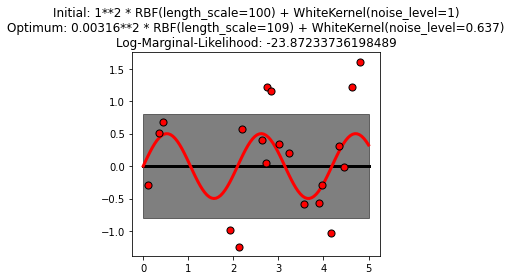

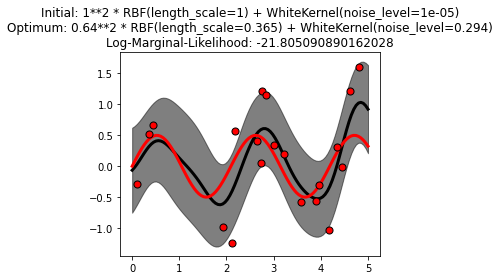

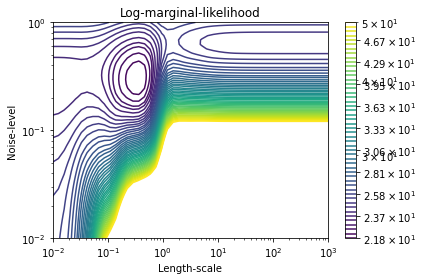

In [1]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel


rng = np.random.RandomState(0)
X = rng.uniform(0, 5, 20)[:, np.newaxis]
y = 0.5 * np.sin(3 * X[:, 0]) + rng.normal(0, 0.5, X.shape[0])

# First run
plt.figure()
kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X, y)
X_ = np.linspace(0, 5, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.plot(X_, 0.5*np.sin(3*X_), 'r', lw=3, zorder=9)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

# Second run
plt.figure()
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X, y)
X_ = np.linspace(0, 5, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.plot(X_, 0.5*np.sin(3*X_), 'r', lw=3, zorder=9)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

# Plot LML landscape
plt.figure()
theta0 = np.logspace(-2, 3, 49)
theta1 = np.logspace(-2, 0, 50)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [[gp.log_marginal_likelihood(np.log([0.36, Theta0[i, j], Theta1[i, j]]))
        for i in range(Theta0.shape[0])] for j in range(Theta0.shape[1])]
LML = np.array(LML).T

vmin, vmax = (-LML).min(), (-LML).max()
vmax = 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)
plt.contour(Theta0, Theta1, -LML,
            levels=level, norm=LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.tight_layout()

plt.show()

# Comparison of kernel ridge and Gaussian process regression
Both kernel ridge regression (KRR) and Gaussian process regression (GPR) learn a target function by employing internally the “kernel trick”. KRR learns a linear function in the space induced by the respective kernel which corresponds to a non-linear function in the original space. The linear function in the kernel space is chosen based on the mean-squared error loss with ridge regularization. GPR uses the kernel to define the covariance of a prior distribution over the target functions and uses the observed training data to define a likelihood function. Based on Bayes theorem, a (Gaussian) posterior distribution over target functions is defined, whose mean is used for prediction.

Time for KRR fitting: 5.306
Time for GPR fitting: 0.112
Time for KRR prediction: 0.072
Time for GPR prediction: 0.090
Time for GPR prediction with standard-deviation: 0.084


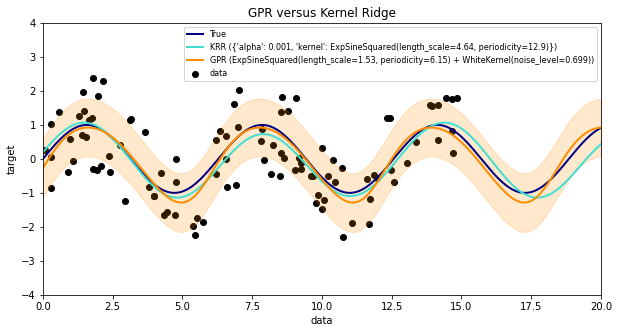

In [2]:
import time

import numpy as np

import matplotlib.pyplot as plt

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared

rng = np.random.RandomState(0)

# Generate sample data
X = 15 * rng.rand(100, 1)
y = np.sin(X).ravel()
y += 3 * (0.5 - rng.rand(X.shape[0]))  # add noise

# Fit KernelRidge with parameter selection based on 5-fold cross validation
param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],
              "kernel": [ExpSineSquared(l, p)
                         for l in np.logspace(-2, 2, 10)
                         for p in np.logspace(0, 2, 10)]}
kr = GridSearchCV(KernelRidge(), param_grid=param_grid)
stime = time.time()
kr.fit(X, y)
print("Time for KRR fitting: %.3f" % (time.time() - stime))

gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) \
    + WhiteKernel(1e-1)
gpr = GaussianProcessRegressor(kernel=gp_kernel)
stime = time.time()
gpr.fit(X, y)
print("Time for GPR fitting: %.3f" % (time.time() - stime))

# Predict using kernel ridge
X_plot = np.linspace(0, 20, 10000)[:, None]
stime = time.time()
y_kr = kr.predict(X_plot)
print("Time for KRR prediction: %.3f" % (time.time() - stime))

# Predict using gaussian process regressor
stime = time.time()
y_gpr = gpr.predict(X_plot, return_std=False)
print("Time for GPR prediction: %.3f" % (time.time() - stime))

stime = time.time()
y_gpr, y_std = gpr.predict(X_plot, return_std=True)
print("Time for GPR prediction with standard-deviation: %.3f"
      % (time.time() - stime))

# Plot results
plt.figure(figsize=(10, 5))
lw = 2
plt.scatter(X, y, c='k', label='data')
plt.plot(X_plot, np.sin(X_plot), color='navy', lw=lw, label='True')
plt.plot(X_plot, y_kr, color='turquoise', lw=lw,
         label='KRR (%s)' % kr.best_params_)
plt.plot(X_plot, y_gpr, color='darkorange', lw=lw,
         label='GPR (%s)' % gpr.kernel_)
plt.fill_between(X_plot[:, 0], y_gpr - y_std, y_gpr + y_std, color='darkorange',
                 alpha=0.2)
plt.xlabel('data')
plt.ylabel('target')
plt.xlim(0, 20)
plt.ylim(-4, 4)
plt.title('GPR versus Kernel Ridge')
plt.legend(loc="best",  scatterpoints=1, prop={'size': 8})
plt.show()

# Gaussian Process Classification (GPC)

---


The GaussianProcessClassifier implements Gaussian processes (GP) for classification purposes, more specifically for probabilistic classification, where test predictions take the form of class probabilities. GaussianProcessClassifier places a GP prior on a latent function , which is then squashed through a link function to obtain the probabilistic classification. The latent function  is a so-called nuisance function, whose values are not observed and are not relevant by themselves. Its purpose is to allow a convenient formulation of the model, and  is removed (integrated out) during prediction. GaussianProcessClassifier implements the logistic link function, for which the integral cannot be computed analytically but is easily approximated in the binary case.

# Probabilistic predictions with Gaussian process classification (GPC)
This example illustrates the predicted probability of GPC for an RBF kernel with different choices of the hyperparameters. The first figure shows the predicted probability of GPC with arbitrarily chosen hyperparameters and with the hyperparameters corresponding to the maximum log-marginal-likelihood (LML).

While the hyperparameters chosen by optimizing LML have a considerable larger LML, they perform slightly worse according to the log-loss on test data. The figure shows that this is because they exhibit a steep change of the class probabilities at the class boundaries (which is good) but have predicted probabilities close to 0.5 far away from the class boundaries (which is bad) This undesirable effect is caused by the Laplace approximation used internally by GPC.

Log Marginal Likelihood (initial): -17.598
Log Marginal Likelihood (optimized): -3.875
Accuracy: 1.000 (initial) 1.000 (optimized)
Log-loss: 0.214 (initial) 0.319 (optimized)


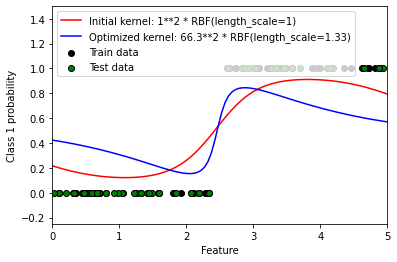

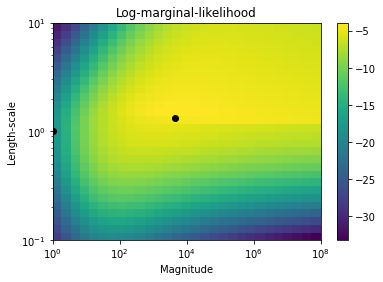

In [3]:
import numpy as np

from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF


# Generate data
train_size = 50
rng = np.random.RandomState(0)
X = rng.uniform(0, 5, 100)[:, np.newaxis]
y = np.array(X[:, 0] > 2.5, dtype=int)

# Specify Gaussian Processes with fixed and optimized hyperparameters
gp_fix = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0),
                                   optimizer=None)
gp_fix.fit(X[:train_size], y[:train_size])

gp_opt = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0))
gp_opt.fit(X[:train_size], y[:train_size])

print("Log Marginal Likelihood (initial): %.3f"
      % gp_fix.log_marginal_likelihood(gp_fix.kernel_.theta))
print("Log Marginal Likelihood (optimized): %.3f"
      % gp_opt.log_marginal_likelihood(gp_opt.kernel_.theta))

print("Accuracy: %.3f (initial) %.3f (optimized)"
      % (accuracy_score(y[:train_size], gp_fix.predict(X[:train_size])),
         accuracy_score(y[:train_size], gp_opt.predict(X[:train_size]))))
print("Log-loss: %.3f (initial) %.3f (optimized)"
      % (log_loss(y[:train_size], gp_fix.predict_proba(X[:train_size])[:, 1]),
         log_loss(y[:train_size], gp_opt.predict_proba(X[:train_size])[:, 1])))


# Plot posteriors
plt.figure()
plt.scatter(X[:train_size, 0], y[:train_size], c='k', label="Train data",
            edgecolors=(0, 0, 0))
plt.scatter(X[train_size:, 0], y[train_size:], c='g', label="Test data",
            edgecolors=(0, 0, 0))
X_ = np.linspace(0, 5, 100)
plt.plot(X_, gp_fix.predict_proba(X_[:, np.newaxis])[:, 1], 'r',
         label="Initial kernel: %s" % gp_fix.kernel_)
plt.plot(X_, gp_opt.predict_proba(X_[:, np.newaxis])[:, 1], 'b',
         label="Optimized kernel: %s" % gp_opt.kernel_)
plt.xlabel("Feature")
plt.ylabel("Class 1 probability")
plt.xlim(0, 5)
plt.ylim(-0.25, 1.5)
plt.legend(loc="best")

# Plot LML landscape
plt.figure()
theta0 = np.logspace(0, 8, 30)
theta1 = np.logspace(-1, 1, 29)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [[gp_opt.log_marginal_likelihood(np.log([Theta0[i, j], Theta1[i, j]]))
        for i in range(Theta0.shape[0])] for j in range(Theta0.shape[1])]
LML = np.array(LML).T
plt.plot(np.exp(gp_fix.kernel_.theta)[0], np.exp(gp_fix.kernel_.theta)[1],
         'ko', zorder=10)
plt.plot(np.exp(gp_opt.kernel_.theta)[0], np.exp(gp_opt.kernel_.theta)[1],
         'ko', zorder=10)
plt.pcolor(Theta0, Theta1, LML)
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
plt.xlabel("Magnitude")
plt.ylabel("Length-scale")
plt.title("Log-marginal-likelihood")

plt.show()

# Illustration of Gaussian process classification (GPC) on the XOR dataset
This example illustrates GPC on XOR data. Compared are a stationary, isotropic kernel (RBF) and a non-stationary kernel (DotProduct). On this particular dataset, the DotProduct kernel obtains considerably better results because the class-boundaries are linear and coincide with the coordinate axes. In general, stationary kernels often obtain better results.

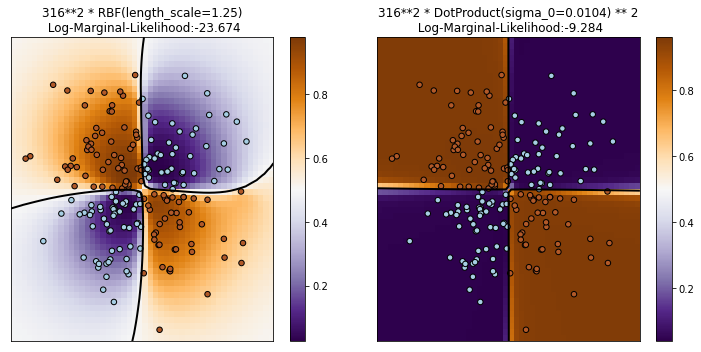

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct


xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

# fit the model
plt.figure(figsize=(10, 5))
kernels = [1.0 * RBF(length_scale=1.0), 1.0 * DotProduct(sigma_0=1.0)**2]
for i, kernel in enumerate(kernels):
    clf = GaussianProcessClassifier(kernel=kernel, warm_start=True).fit(X, Y)

    # plot the decision function for each datapoint on the grid
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    plt.subplot(1, 2, i + 1)
    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0.5], linewidths=2,
                           colors=['k'])
    plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap=plt.cm.Paired,
                edgecolors=(0, 0, 0))
    plt.xticks(())
    plt.yticks(())
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title("%s\n Log-Marginal-Likelihood:%.3f"
              % (clf.kernel_, clf.log_marginal_likelihood(clf.kernel_.theta)),
              fontsize=12)

plt.tight_layout()
plt.show()

# Gaussian process classification (GPC) on iris dataset
This example illustrates the predicted probability of GPC for an isotropic and anisotropic RBF kernel on a two-dimensional version for the iris-dataset. The anisotropic RBF kernel obtains slightly higher log-marginal-likelihood by assigning different length-scales to the two feature dimensions.

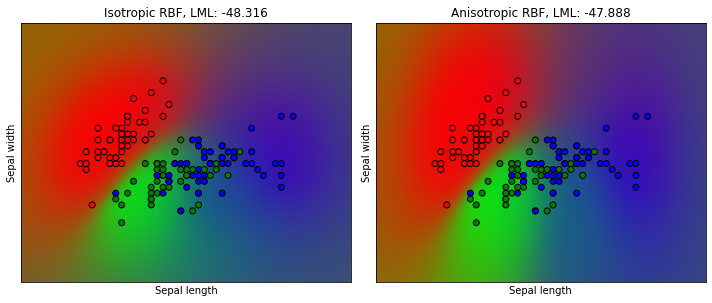

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
y = np.array(iris.target, dtype=int)

h = .02  # step size in the mesh

kernel = 1.0 * RBF([1.0])
gpc_rbf_isotropic = GaussianProcessClassifier(kernel=kernel).fit(X, y)
kernel = 1.0 * RBF([1.0, 1.0])
gpc_rbf_anisotropic = GaussianProcessClassifier(kernel=kernel).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

titles = ["Isotropic RBF", "Anisotropic RBF"]
plt.figure(figsize=(10, 5))
for i, clf in enumerate((gpc_rbf_isotropic, gpc_rbf_anisotropic)):
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(1, 2, i + 1)

    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape((xx.shape[0], xx.shape[1], 3))
    plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=np.array(["r", "g", "b"])[y],
                edgecolors=(0, 0, 0))
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title("%s, LML: %.3f" %
              (titles[i], clf.log_marginal_likelihood(clf.kernel_.theta)))

plt.tight_layout()
plt.show()